# Chapter 5 - AutoRegressive Integrated Moving Average (ARIMA) Models

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product
from statsmodels.tools.eval_measures import rmspe, rmse
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima_process import ArmaProcess
from pmdarima.arima import CHTest


import warnings
warnings.filterwarnings('ignore')

## 5.26 Table B.11 contains 8 years of monthly champagne sales data.
This is seasonal data.

    a. Using the first 7 years of data, develop an appropriate ARIMA model and a procedure for these data.
    
    b. Explain how prediction intervals would be computed.
    
    c. Make one-step-ahead forecasts of the last 12 months. Determine the forecast errors. How well did your procedure work in forecasting the new data?

In [3]:
# Raw data as alternating Month and Miles values
raw_data = [
("Jan-1962", 2.851), ("Sep-1964", 3.528), ("May-1967", 4.968), ("Feb-1962", 2.672), ("Oct-1964", 5.211), ("Jun-1967", 4.677),
("Mar-1962", 2.755), ("Nov-1964", 7.614), ("Jul-1967", 3.523),("Apr-1962", 2.721), ("Dec-1964", 9.254), ("Aug-1967", 1.821),
("May-1962", 2.946), ("Jan-1965", 5.375), ("Sep-1967", 5.222),("Jun-1962", 3.036), ("Feb-1965", 3.088), ("Oct-1967", 6.873),
("Jul-1962", 2.282), ("Mar-1965", 3.718), ("Nov-1967", 10.803),("Aug-1962", 2.212), ("Apr-1965", 4.514), ("Dec-1967", 13.916),
("Sep-1962", 2.922), ("May-1965", 4.520), ("Jan-1968", 2.639),("Oct-1962", 4.301), ("Jun-1965", 4.539), ("Feb-1968", 2.899),
("Nov-1962", 5.764), ("Jul-1965", 3.663), ("Mar-1968", 3.370),("Dec-1962", 7.132), ("Aug-1965", 1.643), ("Apr-1968", 3.740),
("Jan-1963", 2.541), ("Sep-1965", 4.739), ("May-1968", 2.927),("Feb-1963", 2.475), ("Oct-1965", 5.428), ("Jun-1968", 3.986),
("Mar-1963", 3.031), ("Nov-1965", 8.314), ("Jul-1968", 4.217),("Apr-1963", 3.266), ("Dec-1965", 10.651), ("Aug-1968", 1.738),
("May-1963", 3.776), ("Jan-1966", 3.633), ("Sep-1968", 5.221),("Jun-1963", 3.230), ("Feb-1966", 4.292), ("Oct-1968", 6.424),
("Jul-1963", 3.028), ("Mar-1966", 4.154), ("Nov-1968", 9.842),("Aug-1963", 1.759), ("Apr-1966", 4.121), ("Dec-1968", 13.076),
("Sep-1963", 3.595), ("May-1966", 4.647), ("Jan-1969", 3.934),("Oct-1963", 4.474), ("Jun-1966", 4.753), ("Feb-1969", 3.162),
("Nov-1963", 6.838), ("Jul-1966", 3.965), ("Mar-1969", 4.286),("Dec-1963", 8.357), ("Aug-1966", 1.723), ("Apr-1969", 4.676),
("Jan-1964", 3.113), ("Sep-1966", 5.048), ("May-1969", 5.010),("Feb-1964", 3.006), ("Oct-1966", 6.922), ("Jun-1969", 4.874),
("Mar-1964", 4.047), ("Nov-1966", 9.858), ("Jul-1969", 4.633),("Apr-1964", 3.523), ("Dec-1966", 11.331), ("Aug-1969", 1.659),
("May-1964", 3.937), ("Jan-1967", 4.016), ("Sep-1969", 5.951),("Jun-1964", 3.986), ("Feb-1967", 3.957), ("Oct-1969", 6.981),
("Jul-1964", 3.260), ("Mar-1967", 4.510), ("Nov-1969", 9.851),("Aug-1964", 1.573), ("Apr-1967", 4.276), ("Dec-1969", 12.670),
]

# Convert to DataFrame
df_Champagne = pd.DataFrame(raw_data, columns=['Month', 'Sales'])

# Convert 'Month' column to datetime format and set as index
df_Champagne['Month'] = pd.to_datetime(df_Champagne['Month'], format='%b-%Y')
df_Champagne.set_index('Month', inplace=True)
df_Champagne.sort_index(inplace=True)

# Display the first rows
df_Champagne.head()

,Sales
Month,
1962-01-01,2.851
1962-02-01,2.672
1962-03-01,2.755
1962-04-01,2.721
1962-05-01,2.946


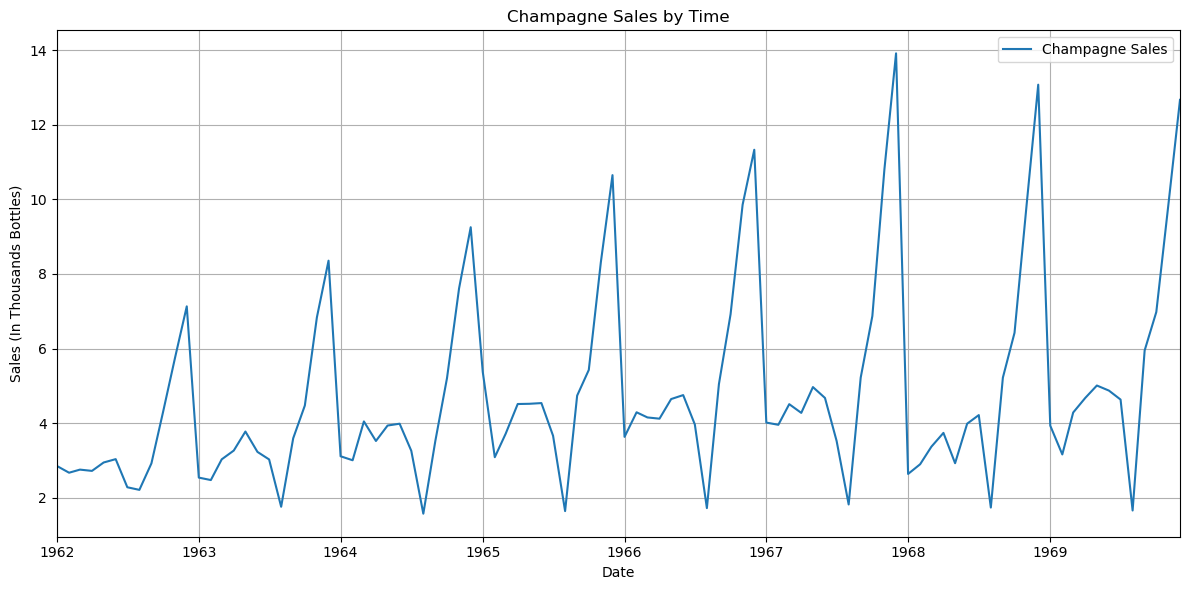

In [4]:
# Plot actual and fitted serie
plt.figure(figsize=(12, 6))                                      

plt.plot(df_Champagne.index, df_Champagne['Sales'], label='Champagne Sales')     

plt.title('Champagne Sales by Time')                      
plt.xlabel('Date')                                        
plt.ylabel('Sales (In Thousands Bottles)')  
plt.xlim(pd.to_datetime('1962-01-01'), pd.to_datetime('1969-12-01'))
plt.grid(True)                                            
plt.legend()                                             
plt.tight_layout()                                       
plt.show();

In [5]:
# Split the data
train = df_Champagne[df_Champagne.index.year < 1969]     # All data before 1969
test = df_Champagne[df_Champagne.index.year == 1969]     # All data in 1969

# Show the results
print("Train shape:", train.shape)
print("Test shape:", test.shape)
print()
train.tail(), print(), test.head()

Train shape: (84, 1)
Test shape: (12, 1)




(             Sales
 Month             
 1968-08-01   1.738
 1968-09-01   5.221
 1968-10-01   6.424
 1968-11-01   9.842
 1968-12-01  13.076,
 None,
             Sales
 Month            
 1969-01-01  3.934
 1969-02-01  3.162
 1969-03-01  4.286
 1969-04-01  4.676
 1969-05-01  5.010)

In [6]:
champagne_series = train['Sales']

In [7]:
def determine_nonseasonal_d(series, max_d=2, alpha=0.05):
    
    for d in range(0, max_d + 1):
        if d == 0:
            tested_series = series.dropna()
        else:
            tested_series = series.diff(d).dropna()
        
        adf_result = adfuller(tested_series)
        p_value = adf_result[1]
        
        print(f"d = {d} | ADF Statistic = {adf_result[0]:.4f}, p-value = {p_value:.4f}")
        
        if p_value < alpha:
            print(f"-> Series is stationary after differencing d = {d}")
            return d
    
    print("-> Series is non-stationary even after maximum differencing.")
    return max_d
    

d = determine_nonseasonal_d(champagne_series)
print(f"\nFinal non-seasonal differencing term (d): {d}")

d = 0 | ADF Statistic = -2.3084, p-value = 0.1693
d = 1 | ADF Statistic = -21.5283, p-value = 0.0000
-> Series is stationary after differencing d = 1

Final non-seasonal differencing term (d): 1


In [8]:
def determine_seasonal_d(serie, seasonal_period=12, max_D=2, alpha=0.05):
    
    for D in range(0, max_D + 1):
        if D == 0:
            tested_series = serie.dropna()
        else:
            tested_series = serie.diff(seasonal_period * D).dropna()

        adf_result = adfuller(tested_series)
        p_value = adf_result[1]

        print(f"D = {D} | ADF Statistic = {adf_result[0]:.4f}, p-value = {p_value:.4f}")
        
        if p_value < alpha:
            print(f"-> Series is stationary after seasonal differencing D = {D}")
            return D

    print("\n-> Series is non-stationary even after maximum seasonal differencing.")
    return max_D

D = determine_seasonal_d(champagne_series, seasonal_period=12)
print(f"\nFinal seasonal differencing term (D): {D}")

D = 0 | ADF Statistic = -2.3084, p-value = 0.1693
D = 1 | ADF Statistic = -6.5831, p-value = 0.0000
-> Series is stationary after seasonal differencing D = 1

Final seasonal differencing term (D): 1


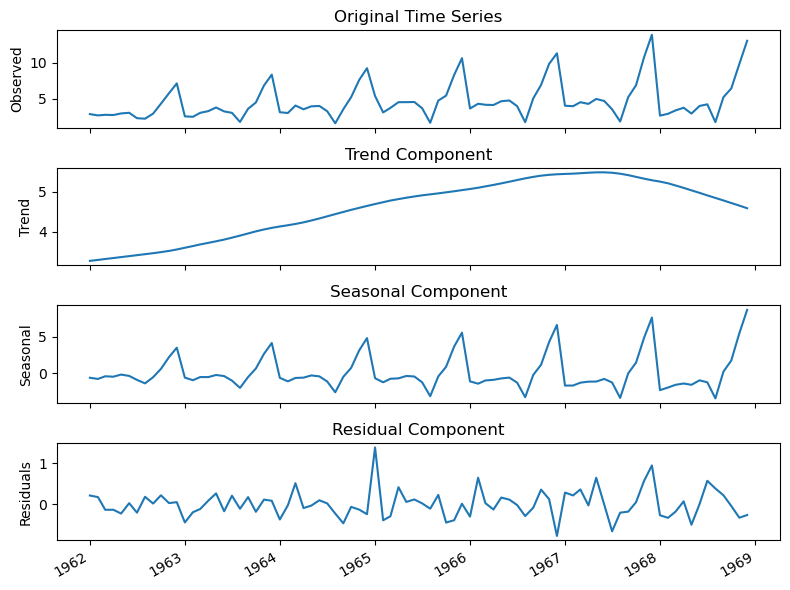

In [9]:
decom_air = STL(champagne_series, period=12).fit()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(8,6))

ax1.plot(decom_air.observed)
ax1.set_ylabel('Observed')
ax1.set_title("Original Time Series")

ax2.plot(decom_air.trend)
ax2.set_ylabel('Trend')
ax2.set_title("Trend Component")

ax3.plot(decom_air.seasonal)
ax3.set_ylabel('Seasonal')
ax3.set_title("Seasonal Component")

ax4.plot(decom_air.resid)
ax4.set_ylabel('Residuals')
ax4.set_title("Residual Component")

fig.autofmt_xdate()
plt.tight_layout()
plt.show();

In [10]:
# Perform a full search over the same grid as your manual SARIMAX model
auto_model = pm.auto_arima(
    champagne_series,           # The time series data
    seasonal=True,              # Enable seasonal component
    m=12,                       # 12 months (seasonal period)
    d=1,                        # Set differencing 
    D=1,                        # Set seasonal differencing
    start_p=0, max_p=3,         # p 
    start_q=0, max_q=3,         # q 
    start_P=0, max_P=3,         # P 
    start_Q=0, max_Q=3,         # Q 
    stepwise=False,             # Disable stepwise search (enable full grid search)
    trace=True,                 # Print model search progress
    error_action='ignore',      # Ignore errors and continue
    suppress_warnings=True,     # Suppress convergence warnings
    information_criterion='aic' # Use AIC to choose the best model
)

# Print the best model found
print(f"Best model: SARIMA{auto_model.order}{auto_model.seasonal_order}")

 ARIMA(0,1,0)(0,1,0)[12]             : AIC=203.022, Time=0.02 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=199.981, Time=0.07 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=195.219, Time=0.13 sec
 ARIMA(0,1,0)(0,1,3)[12]             : AIC=197.169, Time=0.76 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=196.812, Time=0.04 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=196.086, Time=0.13 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=197.152, Time=0.20 sec
 ARIMA(0,1,0)(1,1,3)[12]             : AIC=inf, Time=4.16 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=195.287, Time=0.09 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=196.957, Time=0.37 sec
 ARIMA(0,1,0)(2,1,2)[12]             : AIC=198.956, Time=0.37 sec
 ARIMA(0,1,0)(2,1,3)[12]             : AIC=200.951, Time=2.22 sec
 ARIMA(0,1,0)(3,1,0)[12]             : AIC=196.986, Time=0.75 sec
 ARIMA(0,1,0)(3,1,1)[12]             : AIC=198.956, Time=3.36 sec
 ARIMA(0,1,0)(3,1,2)[12]             : AIC=200.956, Time=1.70 sec
 ARIMA(0,1,1)(

In [11]:
def combinator(items, r=1):
    combo = [i for i in product(*items, repeat=r)]  # Generate Cartesian product of input lists
    return combo                                    # Return the list of combinations


P_ns, Q_ns = [list(range(4))]*2          # Define search ranges for non-seasonal parameters (p, q): each from 0 to 3
P_s, Q_s = [list(range(4))]*2             # Define search ranges for seasonal parameters (P, Q): each from 0 to 3
d = 1
D = 1
S = 12

total = (P_ns[-1] + 1) * (Q_ns[-1] + 1) * (P_s[-1] + 1) * (Q_s[-1]+ 1)
print(f'Total number of models: {total}')

vals = combinator([P_ns, [d], Q_ns, P_s, [D], Q_s])  # Generate all combinations of SARIMA parameter sets

score = {}                                     # Dictionary to store model evaluation metrics

for i, (p, d, q, P, D, Q) in enumerate(vals):  # Iterate over all parameter combinations
    if i % 15 == 0:                            # Print progress every 15 models
        print(f'Running model #{i} using SARIMA({p},{d},{q})({P},{D},{Q},{S})')

    m = SARIMAX(champagne_series,              # Define SARIMA model with current parameter set
                order=(p,d,q), 
                seasonal_order=(P, D, Q, S),   
                enforce_stationarity=False)    # Allow non-stationary models for broader search

    res = m.fit(disp=0, low_memory=True)       # Fit the model silently

    score[i] = {                               # Store model results and evaluation metrics
        'non-seasonal order': (p, d, q),      
        'seasonal order': (P, D, Q),
        'AIC': res.aic,                        # Akaike Information Criterion
        'AICc': res.aicc,                      # Corrected AIC
        'model': res                           # Fitted model object
    }
print()

pd.DataFrame(score).T.sort_values(by='AIC').reset_index().head()

Total number of models: 256
Running model #0 using SARIMA(0,1,0)(0,1,0,12)
Running model #15 using SARIMA(0,1,0)(3,1,3,12)
Running model #30 using SARIMA(0,1,1)(3,1,2,12)
Running model #45 using SARIMA(0,1,2)(3,1,1,12)
Running model #60 using SARIMA(0,1,3)(3,1,0,12)
Running model #75 using SARIMA(1,1,0)(2,1,3,12)
Running model #90 using SARIMA(1,1,1)(2,1,2,12)
Running model #105 using SARIMA(1,1,2)(2,1,1,12)
Running model #120 using SARIMA(1,1,3)(2,1,0,12)
Running model #135 using SARIMA(2,1,0)(1,1,3,12)
Running model #150 using SARIMA(2,1,1)(1,1,2,12)
Running model #165 using SARIMA(2,1,2)(1,1,1,12)
Running model #180 using SARIMA(2,1,3)(1,1,0,12)
Running model #195 using SARIMA(3,1,0)(0,1,3,12)
Running model #210 using SARIMA(3,1,1)(0,1,2,12)
Running model #225 using SARIMA(3,1,2)(0,1,1,12)
Running model #240 using SARIMA(3,1,3)(0,1,0,12)
Running model #255 using SARIMA(3,1,3)(3,1,3,12)



,index,non-seasonal order,seasonal order,AIC,AICc,model
0,197,"(3, 1, 0)","(1, 1, 1)",12.0,13.714286,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
1,35,"(0, 1, 2)","(0, 1, 3)",83.387164,86.747164,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
2,123,"(1, 1, 3)","(2, 1, 3)",83.741431,94.741431,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
3,51,"(0, 1, 3)","(0, 1, 3)",83.876873,88.746439,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
4,43,"(0, 1, 2)","(2, 1, 3)",84.023959,90.284828,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...


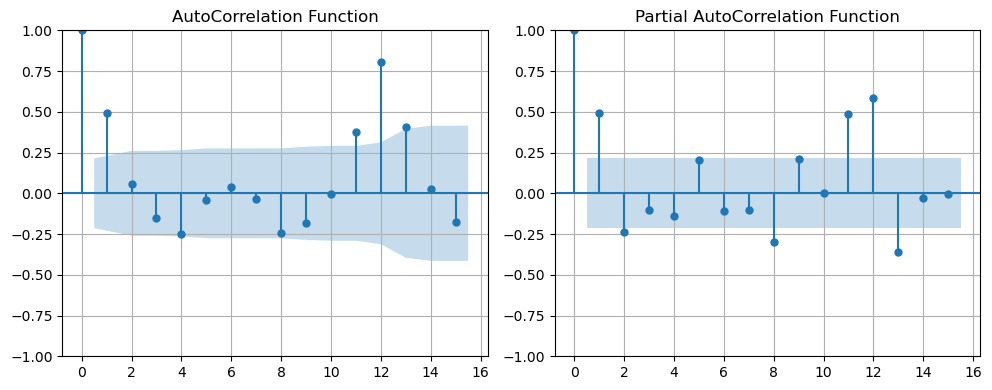

In [12]:
# Create a 1x2 grid for subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))  

# Interest Rate Data
plot_acf(champagne_series, ax=axes[0], lags=15)
axes[0].set_title("AutoCorrelation Function", fontsize=12)
axes[0].grid(True)

# Simulated Random Walk Data
plot_pacf(champagne_series, ax=axes[1], lags=15)
axes[1].set_title("Partial AutoCorrelation Function", fontsize=12)
axes[1].grid(True)

plt.tight_layout()
plt.show()

**ACF (Left Plot)**

    seasonal = 12
    q = 1
    Q = 1 (spike near lag 12)

**PACF (Right Plot)**

    p = 1 or 2
    P = 1 (seasonality around lag 12)

**Chosen model:** (0,1,2)(0,1,3)[12]

In [13]:
# Define the SARIMA(0,1,2)(0,1,3)[12] model
model_012 = SARIMAX(champagne_series,                    # Time series data
                    order=(0, 1, 2),                     # Non-seasonal order (p,d,q)
                    seasonal_order=(0, 1, 3, 12),        # Seasonal order (P,D,Q,S)
                    enforce_stationarity=False)          # Allow non-stationary behavior

# Fit the model
model_fit_012 = model_012.fit()

# Display summary of the model
print(model_fit_012.summary())

                                         SARIMAX Results                                          
Dep. Variable:                                      Sales   No. Observations:                   84
Model:             SARIMAX(0, 1, 2)x(0, 1, [1, 2, 3], 12)   Log Likelihood                 -35.694
Date:                                    Mon, 07 Apr 2025   AIC                             83.387
Time:                                            14:04:17   BIC                             92.182
Sample:                                        01-01-1962   HQIC                            86.302
                                             - 12-01-1968                                         
Covariance Type:                                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3811      0.245     -1.557      0

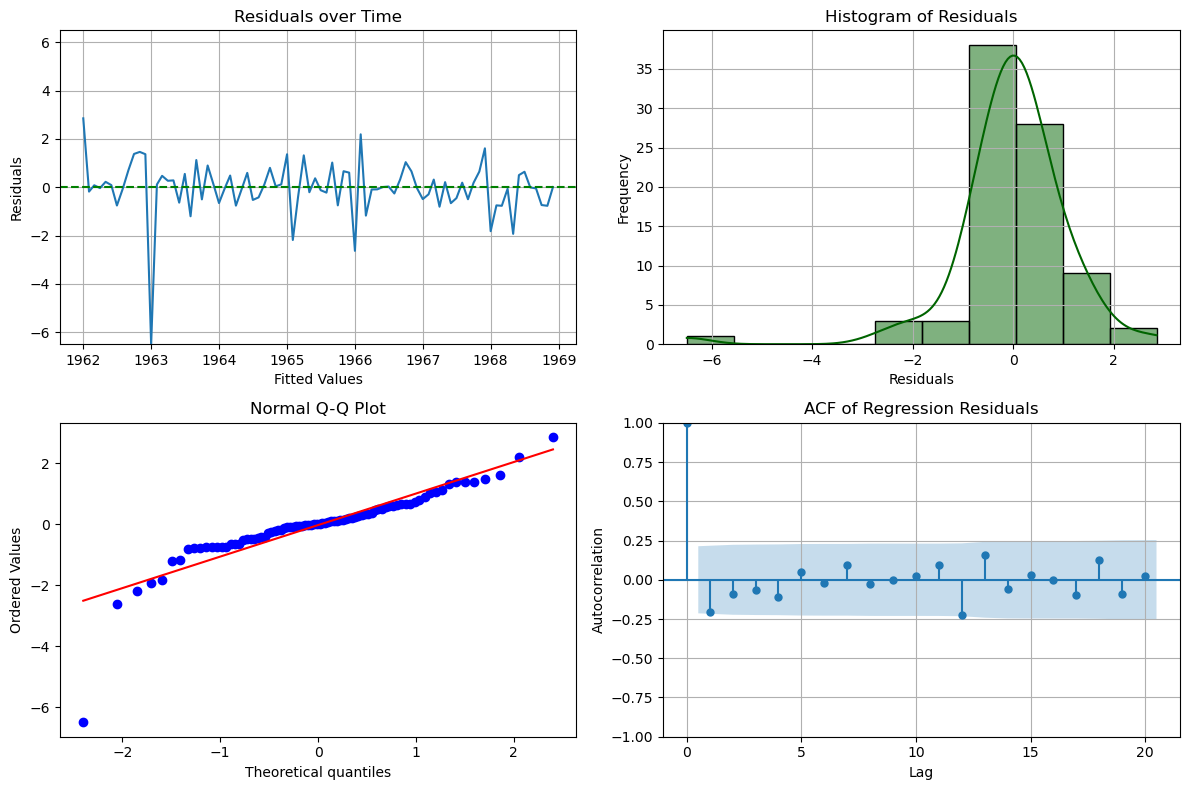

In [14]:
# Extract the residuals (errors) from the fitted model
residuals = model_fit_012.resid  

# Diagnostic plots for the model, including residuals and other model checks
#model_fit.plot_diagnostics(figsize=(10, 8));  

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# 1. Standardized Residuals
axes[0, 0].plot(residuals)
axes[0, 0].axhline(y=0, color='green', linestyle='--')          
axes[0, 0].set_xlabel('Fitted Values')
axes[0, 0].set_ylabel('Residuals')
axes[0, 0].set_title('Residuals over Time')
max_abs = abs(residuals).max()                     # Get max absolute residual
axes[0, 0].set_ylim(-max_abs, max_abs)             # Set symmetric limits
axes[0, 0].grid(True)

# 2. Histogram of Residuals
sns.histplot(residuals, bins=10, edgecolor='black', color='darkgreen', kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Histogram of Residuals')
axes[0, 1].set_xlabel('Residuals')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].grid(True)

# 3. Q-Q Plot
stats.probplot(residuals, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Normal Q-Q Plot')
plt.grid(True)

# 4. Correlogram (ACF)
plot_acf(residuals, lags=20, ax=axes[1, 1])                    
axes[1, 1].set_title('ACF of Regression Residuals')
axes[1, 1].set_xlabel('Lag')
axes[1, 1].set_ylabel('Autocorrelation')
axes[1, 1].grid(True)

plt.tight_layout()
plt.show();

In [15]:
# Apply the Ljung-Box test on the residuals, on 10 lags.
df_residuals = acorr_ljungbox(residuals, np.arange(1, 11, 1))

# Check if all values in 'lb_pvalue' are lower than 0.05
if (df_residuals['lb_pvalue'] > 0.05).all():
    print('All p-values > 0.05; H0: Residuals are independently distributed and uncorrelated.\n')
else:
    print('There are p-values < 0.05; Ha: Residuals are autocorrelated.\n')

# Show Residuals
df_residuals

All p-values > 0.05; H0: Residuals are independently distributed and uncorrelated.



,lb_stat,lb_pvalue
1,3.746552,0.052917
2,4.490413,0.105906
3,4.865766,0.181894
4,5.981433,0.200539
5,6.198902,0.287343
6,6.238131,0.397050
7,7.051695,0.423517
8,7.129790,0.522696
9,7.131623,0.623418
10,7.195452,0.706873


In [16]:
# Forecast the next 12 time points
forecast_12m = model_fit_012.get_forecast(steps=12)

# Extract predicted mean and confidence intervals
forecast_mean_12 = forecast_12m.predicted_mean
conf_int_12 = forecast_12m.conf_int()

# Assign forecasts to the test DataFrame
test['Forecast'] = forecast_mean_12.values                                # Forecast mean

test['Error'] = test['Forecast'] - test['Sales']

test['Lower 95% CI'] = conf_int_12.iloc[:, 0].values                      # Lower bound
test['Upper 95% CI'] = conf_int_12.iloc[:, 1].values                      # Upper bound

# Show the updated test DataFrame
test

,Sales,Forecast,Error,Lower 95% CI,Upper 95% CI
Month,,,,,
1969-01-01,3.934,1.923042,-2.010958,0.564686,3.281399
1969-02-01,3.162,2.717964,-0.444036,1.124509,4.311420
1969-03-01,4.286,3.316026,-0.969974,1.720613,4.911439
1969-04-01,4.676,3.081269,-1.594731,1.470714,4.691824
1969-05-01,5.010,2.795388,-2.214612,1.169832,4.420945
1969-06-01,4.874,3.461213,-1.412787,1.820792,5.101634
1969-07-01,4.633,3.325748,-1.307252,1.670597,4.980900
1969-08-01,1.659,1.230759,-0.428241,-0.438993,2.900512
1969-09-01,5.951,4.635425,-1.315575,2.951199,6.319652


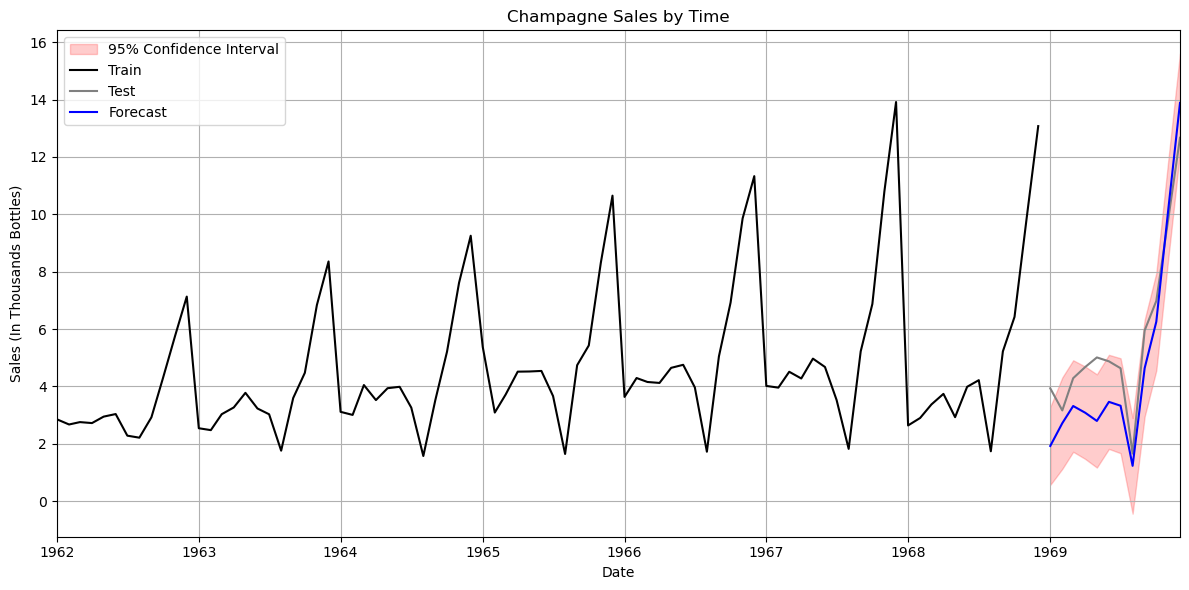

In [17]:
# Plot actual and fitted serie
plt.figure(figsize=(12, 6))                                      

# Plot 95% confidence interval
plt.fill_between(test.index,
                 conf_int_12.iloc[:, 0],     # Lower bound
                 conf_int_12.iloc[:, 1],     # Upper bound
                 color='red', alpha=0.2, label='95% Confidence Interval')

plt.plot(train.index, train['Sales'], label='Train', color='black')       # Train
plt.plot(test.index, test['Sales'], label='Test', color='gray')           # Test

plt.plot(test.index, test['Forecast'], label='Forecast', color='blue')    # Forecast

plt.title('Champagne Sales by Time')                      
plt.xlabel('Date')                                        
plt.ylabel('Sales (In Thousands Bottles)')  
plt.xlim(pd.to_datetime('1962-01-01'), pd.to_datetime('1969-12-01'))
plt.grid(True)                                            
plt.legend()                                             
plt.tight_layout()                                       
plt.show();

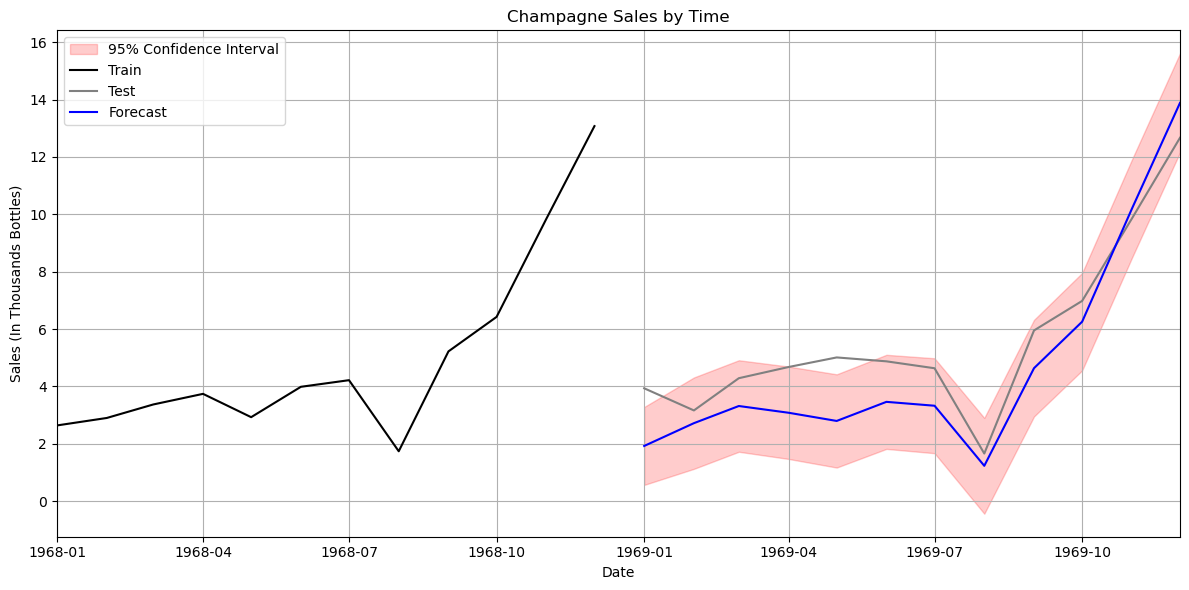

In [18]:
# Plot actual and fitted serie
plt.figure(figsize=(12, 6))                                      

# Plot 95% confidence interval
plt.fill_between(test.index,
                 conf_int_12.iloc[:, 0],     # Lower bound
                 conf_int_12.iloc[:, 1],     # Upper bound
                 color='red', alpha=0.2, label='95% Confidence Interval')

plt.plot(train.index, train['Sales'], label='Train', color='black')       # Train
plt.plot(test.index, test['Sales'], label='Test', color='gray')           # Test

plt.plot(test.index, test['Forecast'], label='Forecast', color='blue')    # Forecast

plt.title('Champagne Sales by Time')                      
plt.xlabel('Date')                                        
plt.ylabel('Sales (In Thousands Bottles)')  
plt.xlim(pd.to_datetime('1968-01-01'), pd.to_datetime('1969-12-01'))
plt.grid(True)                                            
plt.legend()                                             
plt.tight_layout()                                       
plt.show();

In [19]:
# Calculate MAPE
mape = (np.abs(test['Error']) / test['Sales']).mean() * 100

# Print the result
print(f"MAPE SARIMA(0,1,2)(1,1,3)[12] model: {mape:.2f}%")

MAPE SARIMA(0,1,2)(1,1,3)[12] model: 24.56%
